<a href="https://colab.research.google.com/github/platypusjerry/Airbnb-chicago_analysis/blob/main/airbnb_chicago_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Analysis of Airbnb listings, Chicago**
Airbnb's publically available data of a large number of listings is a critical aspect for the company. This data is further cleaned and analyzed to provide various insights for the beneficiaries of the company. Various purposes include security decisions, business decisions, optimizing peer-to-peer compatibility, improving marketing and branding etc.
 
Let us take a look into some of the visualizations that can be inferred from this dataset. We will try to understand the features that drive certain user decisions. Doing so, we shall subsequently try to build a model that predicts the price of an Airbnb listing. We will try different methods and evaluate each, thus finding the most accurate among them all for scaling into a real-world use.

In [170]:
pip install eli5

In [245]:
#importing libraries
import sys
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
%matplotlib inline
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'browser'
import urllib.request
from urllib.request import urlopen
import json
from PIL import Image
from wordcloud import WordCloud
import requests
from io import BytesIO
import functools

import re
import eli5
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import xgboost as xgb
from xgboost import plot_importance
from sklearn.svm import LinearSVR
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import LabelEncoder, normalize, scale
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot, plot_model
from tensorflow.keras.models import load_model
from IPython.display import SVG

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
pd.options.mode.chained_assignment = None  # default='warn'

In [6]:
#reading the data-set
url1 = 'https://raw.githubusercontent.com/platypusjerry/Airbnb-chicago_analysis/main/data/listings_2.csv'
url2 = 'https://raw.githubusercontent.com/platypusjerry/Airbnb-chicago_analysis/main/data/listings_1.csv'
url3 = 'https://raw.githubusercontent.com/platypusjerry/Airbnb-chicago_analysis/main/data/listings_3.csv'
listing = pd.read_csv(url3)

listing.rename(columns = {'neighbourhood_cleansed':'neighbourhood'}, inplace = True)
listing.head(3)

,id,name,description,neighborhood_overview,host_id,host_name,host_about,host_is_superhost,neighbourhood,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,license,calculated_host_listings_count,reviews_per_month
0,2384,Hyde Park - Walk to University of Chicago,"If you have been fully vaccinated, you are inv...",The apartment is less than one block from beau...,2613,Rebecca,My 2 bdrm apartment is a 2nd floor walk-up in ...,t,Hyde Park,41.78790,-87.58780,Private room,1,1.0,1.0,"[""Hot water kettle"", ""Wine glasses"", ""Kitchen""...",$85.00,1,90,338,185,4.99,R17000015609,1,2.45
1,7126,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhoo...,"Ukrainian Village was just named ""Hottest Neig...",17928,Sarah,We live in Chicago. We love to travel and see ...,t,West Town,41.90166,-87.68021,Entire home/apt,2,1.0,1.0,"[""Kitchen"", ""Free street parking"", ""Long term ...",$65.00,2,60,59,401,4.66,R18000034991,1,3.32
2,10945,The Biddle House (#1),Beautiful first floor apartment in Historic Ol...,NaN,33004,At Home Inn,"Hi, we're Bob and Liz Biddle, long time Chicag...",t,Lincoln Park,41.91196,-87.63981,Entire home/apt,4,2.0,2.0,"[""Kitchen"", ""Free street parking"", ""Shampoo"", ...",$143.00,4,180,102,28,4.50,2120297,10,0.32


In [7]:
#shape of the data set we are working with
print(listing.shape)
print('Rows = {rows} in total and Columns = {columns} in total'.format(rows=listing.shape[0],columns=listing.shape[1]))

(6366, 25)
Rows = 6366 in total and Columns = 25 in total


# **EXPLORATORY DATA ANALYSIS**

### **CLEANING THE DATA**

In [8]:
total_nan = listing.isna().sum().sort_values(ascending=False)
percentage_nan = (total_nan / listing.shape[0]) * 100
nan = pd.concat([total_nan, percentage_nan], axis=1, keys=['Total NaN values', 'Percentage of NaN values'])
nan

,Total NaN values,Percentage of NaN values
host_about,1985,31.181276
neighborhood_overview,1703,26.751492
reviews_per_month,1084,17.027961
review_scores_rating,1084,17.027961
bedrooms,537,8.435438
license,335,5.262331
beds,81,1.272385
description,14,0.219918
host_name,1,0.015708
host_is_superhost,1,0.015708


We can see now that certain columns are void/are storing null values. We wish to clean the dataset to make our analysis easier. 
We shall replace the missing values in different RELEVANT columns appropriately. We can also drop the columns that will be irrelavant to us in any future exploration. Following dropped columns also entail redundant features which are necessary to be dropped, since they do not provide any further meaningful insight into an analysis as well as importance to a learning model.

In [9]:
cols1 = ['reviews_per_month', 'review_scores_rating']
cols2 = ['host_name', 'host_about', 'neighborhood_overview', 'license', 'description', 'host_name']
for col in cols1:
  listing[col].fillna(0,inplace = True)
for col in cols2:
  listing[col].fillna("N/A", inplace = True)

listing['host_is_superhost'].fillna("t",inplace = True)

Now let's find the average values of bedrooms and beds to replace the missing. We are not concerned with outliers as we will see ahead that they are in scarcity. Hence we can approximately replace for now.

In [10]:
listing['beds'].fillna(round(listing['beds'].mean()), inplace = True)
listing['bedrooms'].fillna(round(listing['bedrooms'].mean()), inplace = True)

In [11]:
#removing $ sign and commas from price object values to get float datatype
listing['price'] = listing['price'].map(lambda x: x.lstrip('$')).convert_dtypes()
listing["price"] = listing["price"].str.replace(",","").astype(float)

In [12]:
#listing.isnull().sum()

### **TOP AREAS WITH HIGHEST NUMBER OF LISTINGS**
Since we aren't given neighbourhood groups in the dataset, let us take a look at the different unique neighbourhoods and listing concentrations around them.

In [13]:
print(listing.neighbourhood.unique())
listing.neighbourhood.unique().shape

['Hyde Park' 'West Town' 'Lincoln Park' 'Near North Side' 'Logan Square'
 'Uptown' 'Near South Side' 'North Center' 'Albany Park' 'Pullman'
 'West Ridge' 'Near West Side' 'Edgewater' 'Bridgeport' 'Kenwood'
 'Lake View' 'Loop' 'Lincoln Square' 'Grand Boulevard' 'Forest Glen'
 'Lower West Side' 'East Garfield Park' 'Rogers Park' 'North Lawndale'
 'Oakland' 'Beverly' 'Chatham' 'Mckinley Park' 'Woodlawn' 'Avondale'
 'Humboldt Park' 'Norwood Park' 'Portage Park' 'Washington Park'
 'South Lawndale' 'Morgan Park' 'Dunning' 'West Lawn' 'South Shore'
 'Irving Park' 'Armour Square' 'South Deering' 'West Garfield Park'
 'Hermosa' 'Douglas' 'Hegewisch' 'North Park' 'Greater Grand Crossing'
 'West Elsdon' 'Jefferson Park' 'Ashburn' 'Belmont Cragin'
 'Garfield Ridge' 'Austin' 'Brighton Park' 'West Pullman' 'Archer Heights'
 'Edison Park' 'Mount Greenwood' 'Englewood' 'Chicago Lawn'
 'South Chicago' 'Montclare' 'Clearing' 'Roseland' 'Calumet Heights'
 'New City' 'Fuller Park' 'Auburn Gresham' 'Washin

(77,)

Now let us look at the listings in each of these neighbourhoods-

In [14]:
print(listing.neighbourhood.value_counts())

Near North Side    722
West Town          679
Lake View          574
Logan Square       393
Near West Side     372
                  ... 
Burnside             1
Avalon Park          1
West Elsdon          1
Gage Park            1
Edison Park          1
Name: neighbourhood, Length: 77, dtype: int64


showing a count for the top 10 areas with the most number of listings

Near North Side    722
West Town          679
Lake View          574
Logan Square       393
Near West Side     372
Loop               342
Lincoln Park       288
Near South Side    184
Uptown             180
Lower West Side    167
Name: neighbourhood, dtype: int64


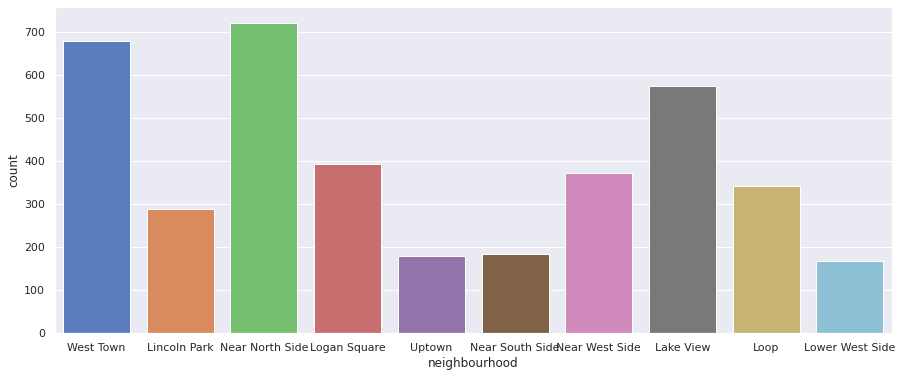

In [15]:
np = listing.neighbourhood.value_counts()
np_1 = np.head(10)
print(np_1)
df_1 = listing.loc[listing['neighbourhood'].isin(np_1.index.tolist())]

sns.set_theme(style="darkgrid")
f,plt_1 = plt.subplots(figsize=(15,6))
plt_2 = sns.countplot(x = "neighbourhood", data = df_1, palette= "muted")
plt.show()

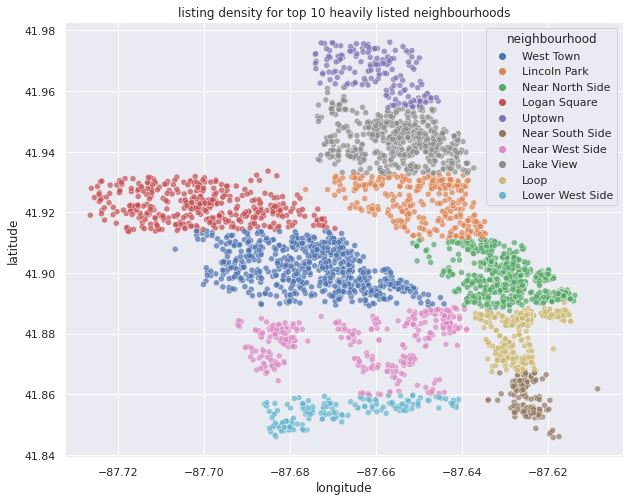

In [16]:
np_1.to_frame()
np_1 = pd.DataFrame(np_1, columns=['neighbourhood'])
np_1.reset_index(level=0, inplace=True)
np_1.rename(columns={'index':'neighbourhood', 'neighbourhood':'listings'})

np_2 = listing.loc[listing['neighbourhood'].isin(['Near North Side','West Town', 'Lake View', 'Logan Square', 'Loop', 'Near West Side', 'Lincoln Park', 'Near South Side', 'Lower West Side', 'Uptown'])]

np_3 = np_2[['neighbourhood','latitude', 'longitude']]

plt.figure(figsize=(10,8))

g = sns.scatterplot(data=np_3, y="latitude", x="longitude", hue="neighbourhood", alpha=0.7)
g.set_title('listing density for top 10 heavily listed neighbourhoods');

### **TOP 10 HOSTS BY THE TOTAL NUMBER OF LISTINGS** 

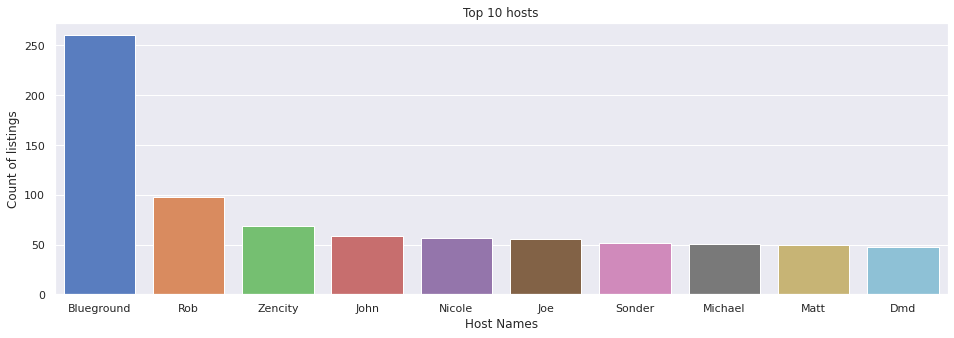

In [17]:
arr_2 = listing.host_name.value_counts().head(10)

sns.set_theme(style="darkgrid")
f,plt_2 = plt.subplots(figsize=(16,5))
plt_2 = sns.barplot(x = arr_2.index, y= arr_2.values, palette="muted")
plt_2.set_ylabel('Count of listings')
plt_2.set_xlabel('Host Names')
plt_2.set_title('Top 10 hosts')
plt.show()


### **PRICES AND NEIGHBOURHOODS- ANALYSIS**

In [18]:
df_5 = listing.groupby('neighbourhood')['price'].mean()

In [19]:
df_5.to_frame()
df_5.sort_values(inplace=True, ascending=False)
print(df_5.head(5))

neighbourhood
Loop               331.394737
West Englewood     268.571429
West Lawn          264.111111
Near North Side    249.343490
Lake View          244.590592
Name: price, dtype: float64


We can see which of the neighbourhood listings have the highest average price per day. Let us visualize the distribution for the five costliest listed neighbourhoods.

In [20]:
n_group = pd.DataFrame(df_5, columns = ['price'])
n_group.reset_index(level=0, inplace=True)
#print(n_group.head(6))

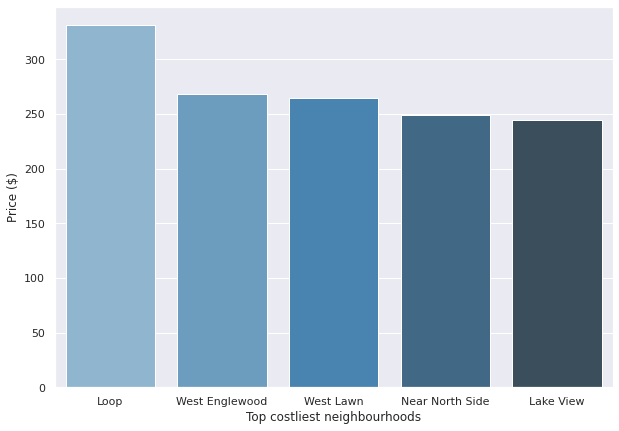

In [21]:
X = n_group['neighbourhood'].head(5)
Y = n_group['price'].head(5)
 
fig = plt.figure(figsize =(10, 7))
 
plt_3 =sns.barplot(x=X, y=Y, data=n_group,
                 palette='Blues_d')
plt_3.set_ylabel('Price ($)')
plt_3.set_xlabel('Top costliest neighbourhoods')
 
plt.show()

Prices heatmap across entire region for all listings. Removing extreme values i.e > $600

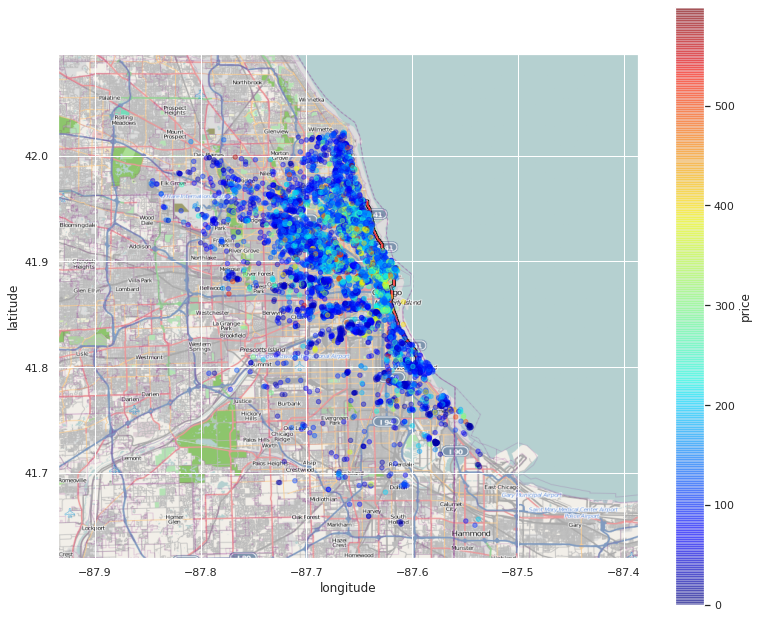

In [22]:
mp1 = listing[listing.price < 600]

i=urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/3/31/Chicago_map_LSD.png')
chic_img=plt.imread(i)

plt.figure(figsize=(13,11))
plt.imshow(chic_img,zorder=0 ,extent=[-87.93482, -87.3864, 41.62, 42.096])  
ax=plt.gca()

plt_4 = mp1.plot(kind='scatter', x='longitude', y='latitude', c='price', ax= ax,
                  cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4)

Let us look at the regions with their most frequent type of room listings

In [ ]:
with urlopen('https://raw.githubusercontent.com/platypusjerry/Airbnb-chicago_analysis/main/neighbourhoods.geojson') as response:
  map_chic = json.load(response)

print(listing["neighbourhood"][0])
print(map_chic['features'][0]["properties"])

fig = px.choropleth_mapbox(listing, geojson=map_chic, color="room_type",
                           locations="neighbourhood", featureidkey="properties.neighbourhood",
                           center={"lat": 45.5517, "lon": -73.7073},
                           mapbox_style="carto-positron", zoom=9)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

Loading this saved plotly thematic map from the project repository

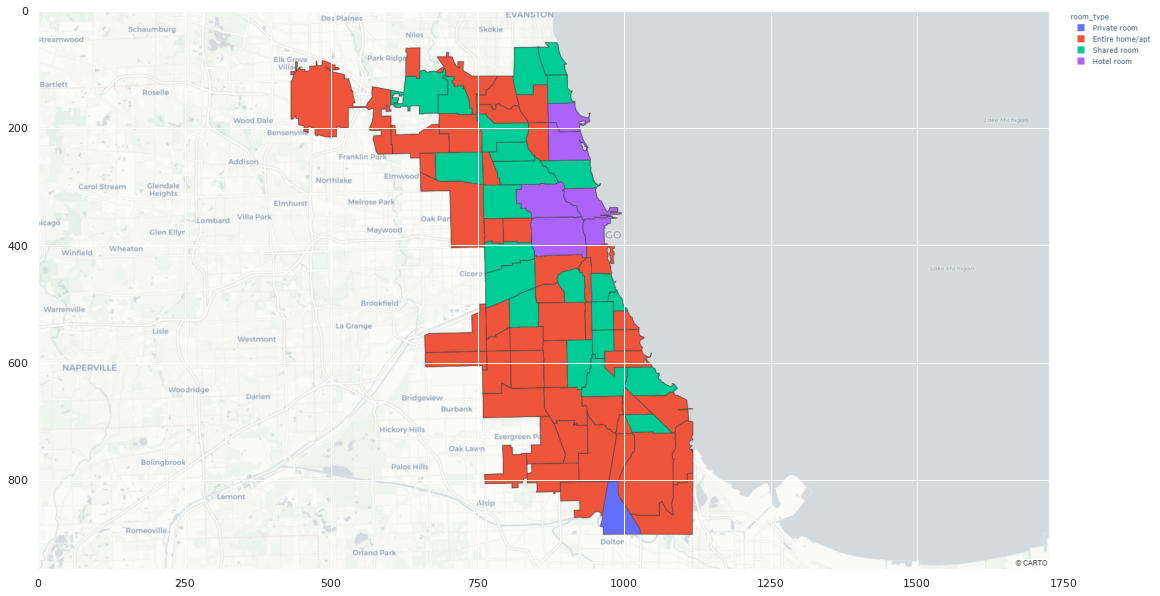

In [25]:
imgurl = 'https://github.com/platypusjerry/Airbnb-chicago_analysis/blob/main/newplot.png?raw=true'
response = requests.get(imgurl)
img = Image.open(BytesIO(response.content))
plt.figure(figsize = (20, 18))
plt.imshow(np.asarray(img))

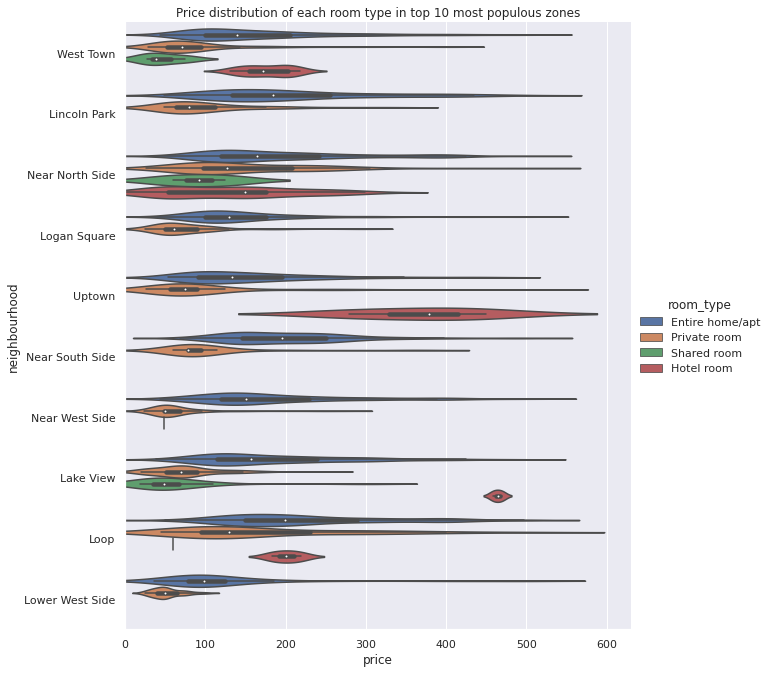

In [26]:
f = sns.catplot(x="price", y="neighbourhood", hue="room_type", data=np_2[np_2['price'] <= 500], scale="width", kind='violin', height=9)
f.axes[0][0].set_xlim(0,)
plt.title('Price distribution of each room type in top 10 most populous zones')
plt.show()

Lastly, to infer better, let us plot the prices for these neighbourhoods with various inherently dependent features that we have in the data-set:

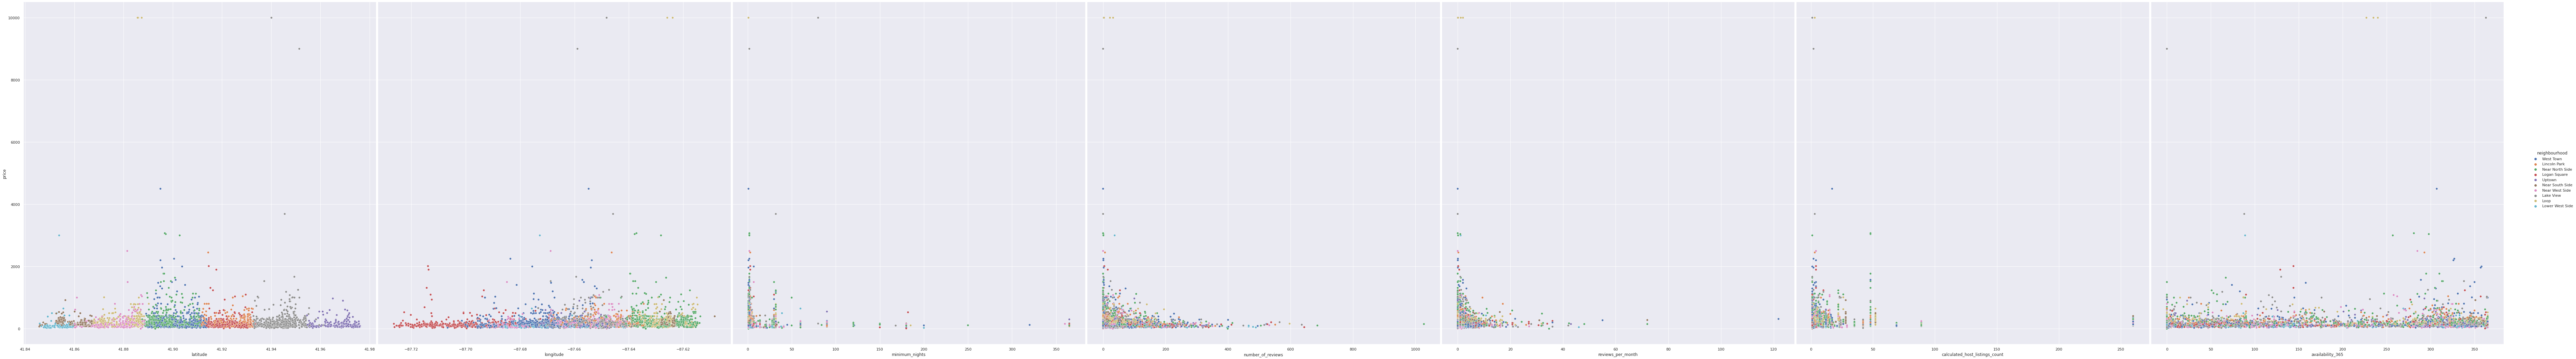

In [27]:
sns.pairplot(np_2, y_vars=['price'], 
             x_vars=['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365'], 
             height=15, hue='neighbourhood')

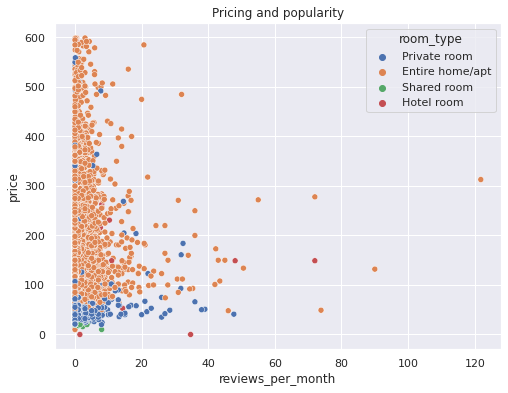

In [28]:
plt.figure(figsize=(8,6))
f = sns.scatterplot(x="reviews_per_month", y='price', hue='room_type', data=listing[listing['price']<600])
f.set_title('Pricing and popularity');

We can conlude from this section that:

*   **Entire apartment Airbnb are the most costliest ones, while also being the most heavily listed**
*   **Shared homes are cheaper, less frequently listed but feature in a couple of the densely listed neighbourhoods, which are major city centres**
*   **More reviewed, hence popular listings are cheaper than others. Entire apartment listings are quite variable but it does stick to the aforementioned trend more often than not. You will only find entire apartment listings which are also decently popular on the higher end of costs. We can explore a price prediction on the basis of these features**
*   **As the minimum days of stay increases, the cost decreases exponentially.**





### **ANALYSING DESCRIPTIONS**

Let's start by looking at the most common words/phrases that are listed in the names of the Airbnbs

In [29]:
omit_words = set(['Chicago', 'chicago', 'Hyde Park', 'West Town', 'Lincoln Park', 'br', '<br>', '</br>' 'space', 'Near North Side', 'Logan', 'Logan Square',
 'Uptown', 'Near South Side', 'North Center', 'Albany Park', 'Pullman',
 'West Ridge', 'Near West Side', 'Edgewater', 'Bridgeport', 'Kenwood',
 'Lake View', 'Loop', 'Lincoln Square', 'Grand Boulevard', 'Forest Glen',
 'Lower West Side', 'East Garfield Park', 'Rogers Park', 'North Lawndale',
 'Oakland', 'Beverly', 'Chatham', 'Mckinley Park', 'Woodlawn', 'Avondale',
 'Humboldt Park', 'Norwood Park', 'Portage Park', 'Washington Park',
 'South Lawndale', 'Morgan Park', 'Dunning', 'West Lawn', 'South Shore',
 'Irving Park', 'Armour Square', 'South Deering', 'West Garfield Park',
 'Hermosa', 'Douglas', 'Hegewisch', 'North Park', 'Greater Grand Crossing',
 'West Elsdon', 'Jefferson Park', 'Ashburn', 'Belmont Cragin',
 'Garfield Ridge', 'Austin', 'Brighton Park', 'West Pullman', 'Archer Heights',
 'Edison Park', 'Mount Greenwood', 'Englewood', 'Chicago Lawn',
 'South Chicago', 'Montclare', 'Clearing', 'Roseland', 'Calumet Heights',
 'New City', 'Fuller Park', 'Auburn Gresham', 'Washington Heights',
 'West Englewood', 'Ohare', 'Avalon Park', 'Burnside', 'Riverdale', 'Gage Park',
 'East Side'])

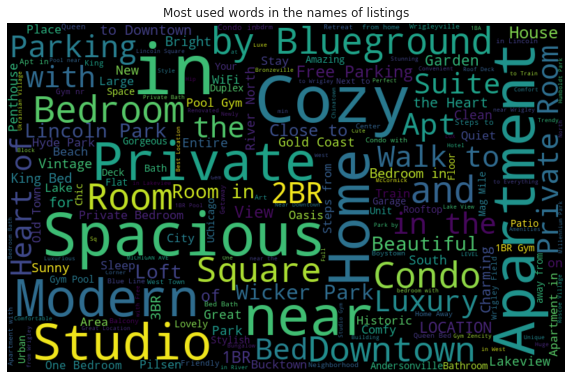

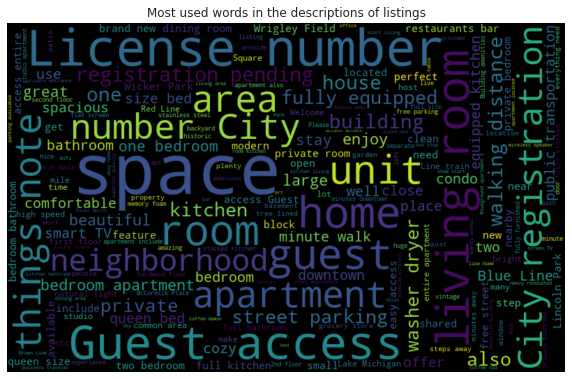

In [30]:
fig, ax = plt.subplots(figsize=(10,7))
text = functools.reduce(lambda a,b: a + " " + str(b), listing.sample(frac=0.3)['name'])
text = ' '.join([w for w in nltk.word_tokenize(text) if w.lower() not in omit_words])
new_stopwords=omit_words.union(text)

wc = WordCloud(width = 800, height = 500, max_font_size = 100, background_color="black",
               stopwords=new_stopwords).generate(text)
ax.imshow(wc, interpolation='bilinear')
ax.set_title("Most used words in the names of listings")
plt.axis("off")
fig.show()


fig, ax = plt.subplots(figsize=(10,7))
stop_2 = set(stopwords.words('english'))
text = functools.reduce(lambda a,b: a + " " + str(b), listing.sample(frac=0.3)['description'])
text = ' '.join([w for w in nltk.word_tokenize(text) if w.lower() not in omit_words])
new_stop_2 = omit_words.union(text)
new_stop_2 = stop_2.union(new_stop_2)

wc = WordCloud(width = 800, height = 500, max_font_size = 100, background_color="black",
               stopwords=new_stop_2).generate(text)
ax.imshow(wc, interpolation='bilinear')
ax.set_title("Most used words in the descriptions of listings")
plt.axis("off")
fig.show()

Lets look at the top n-grams for the top 200 most popular room listings

In [31]:
def top_words(documents, ngram_range=(1,1), unwanted_words=set(), min_occurrences=1):

    unwanted = stop_2.union(unwanted_words)
    vec = CountVectorizer(stop_words = unwanted, ngram_range=ngram_range)
    sum_words = vec.fit_transform(documents).sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    if min_occurrences > 1:
        words_freq = list(filter(lambda x: x[1] >= min_occurrences, words_freq))
    return words_freq

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['albany', 'archer', 'armour', 'ashburn', 'auburn', 'austin', 'avalon', 'avondale', 'belmont', 'beverly', 'boulevard', 'bridgeport', 'brighton', 'burnside', 'calumet', 'center', 'chatham', 'city', 'clearing', 'cragin', 'crossing', 'deering', 'douglas', 'dunning', 'east', 'edgewater', 'edison', 'elsdon', 'englewood', 'forest', 'fuller', 'gage', 'garfield', 'glen', 'grand', 'greater', 'greenwood', 'gresham', 'hegewisch', 'heights', 'hermosa', 'humboldt', 'hyde', 'irving', 'jefferson', 'kenwood', 'lake', 'lawn', 'lawndale', 'lincoln', 'logan', 'loop', 'lower', 'mckinley', 'montclare', 'morgan', 'mount', 'near', 'new', 'north', 'norwood', 'oakland', 'ohare', 'park', 'portage', 'pullman', 'ridge', 'riverdale', 'rogers', 'roseland', 'shore', 'side', 'south', 'space', 'square', 'town', 'uptown', 'vi

Text(0.5, 1.0, 'Top n-grams of the 200 most popular room listings')

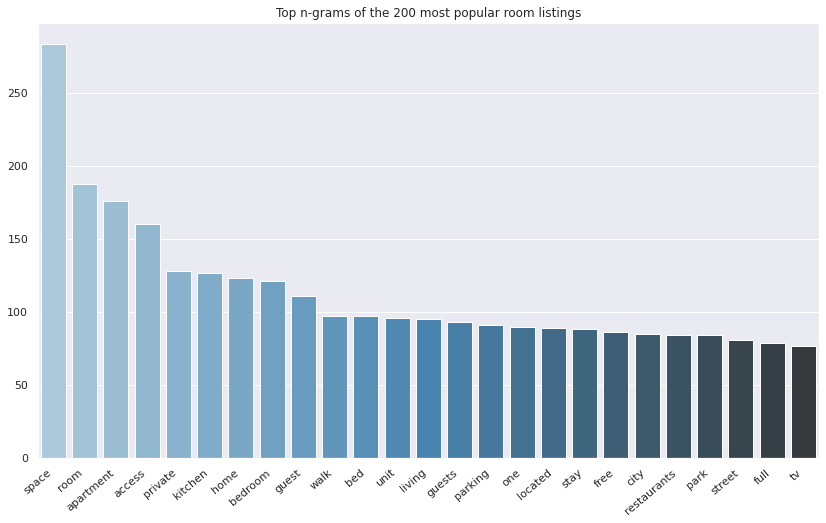

In [32]:
top_ngrams = top_words(listing.sort_values('reviews_per_month', ascending=False)['description'].iloc[:200], ngram_range=(1,2), unwanted_words=omit_words, min_occurrences=10)
top_ngrams = top_ngrams[:25]

fig, ax= plt.subplots(figsize=(14,8))
sns.barplot([x[0] for x in top_ngrams], [x[1] for x in top_ngrams], ax=ax,  palette=("Blues_d"))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Top n-grams of the 200 most popular room listings')


*   **Popular rooms are the ones with access to amenities readily, as well as location advantages. You can further analyse to confirm this by the price and amenities features corresponding to a listing in the dataset**
*   **The immediate neighbourhood is heavily mentioned in the name, whereas the description constains the features of the listing, which is heavily correlated with the price, as we will see ahead**



# **FEATURE ENGINEERING**

We wish to analyse the Amenities feature as it will be a key feature in prediction of prices of a listing

In [33]:
lemmatizer = WordNetLemmatizer()
amen_corpus = []

for i in range(len(listing)):
    review = re.sub('[^a-zA-Z]', ' ', listing.amenities[i])
    review = review.lower()
    review = review.split()
    review = [lemmatizer.lemmatize(word) for word in review if word not in stop_2]
    
    review = ' '.join(review)
    amen_corpus.append(review)
  

Creating a bag of words model using the amenities we are interested in, for feature use in the dataset. We will subsequently make a document-term matrix, and convert the sparse representation into a numpy array, which will be converted to append to our original dataframe.

In [34]:
vect = CountVectorizer(analyzer='word', ngram_range=(1, 2), vocabulary=['dryer', 'washer', 'wifi', 'indoor fireplace', 'Free street parking', 'microwave', 'hot water', 
                                                                      'kitchen', 'refrigerator', 'hair dryer', 'iron', 'Patio or balcony',
                                                                      'heating', 'air conditioning',
                                                                       'breakfast', 'Essentials', 'dishwasher', 'stove',
                                                                      'coffee maker',  'oven', 'cable tv', 'Shared fenced garden or backyard', 'Free parking on premises',
                                                                      'private entrance', 'gym', 'pool', 'Beach essentials', 'Extra pillows and blankets', 'Dishes and silverware'
                                                                      ])
para_matrix = vect.fit(amen_corpus)
#vect.get_feature_names()

amenities_matrix = vect.transform(amen_corpus).toarray()
amenities_matrix

array([[2, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [2, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [2, 1, 1, ..., 0, 0, 0]])

In [35]:
amenities_matrix = pd.DataFrame(amenities_matrix, columns=vect.get_feature_names())
amenities_matrix = amenities_matrix.rename(columns=lambda x: x.replace(" ","_").replace('-','_')) 
listing_final = pd.merge(listing, amenities_matrix, left_index=True, right_index=True)
listing_final = listing_final.drop(['amenities'], axis=1)
listing_final.head(3)

,id,name,description,neighborhood_overview,host_id,host_name,host_about,host_is_superhost,neighbourhood,latitude,longitude,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,license,calculated_host_listings_count,reviews_per_month,dryer,washer,wifi,indoor_fireplace,Free_street_parking,microwave,hot_water,kitchen,refrigerator,hair_dryer,iron,Patio_or_balcony,heating,air_conditioning,breakfast,Essentials,dishwasher,stove,coffee_maker,oven,cable_tv,Shared_fenced_garden_or_backyard,Free_parking_on_premises,private_entrance,gym,pool,Beach_essentials,Extra_pillows_and_blankets,Dishes_and_silverware
0,2384,Hyde Park - Walk to University of Chicago,"If you have been fully vaccinated, you are inv...",The apartment is less than one block from beau...,2613,Rebecca,My 2 bdrm apartment is a 2nd floor walk-up in ...,t,Hyde Park,41.78790,-87.58780,Private room,1,1.0,1.0,85.0,1,90,338,185,4.99,R17000015609,1,2.45,2,1,1,0,0,1,2,1,1,1,1,0,1,0,1,0,0,1,1,2,0,0,0,0,0,0,0,0,0
1,7126,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhoo...,"Ukrainian Village was just named ""Hottest Neig...",17928,Sarah,We live in Chicago. We love to travel and see ...,t,West Town,41.90166,-87.68021,Entire home/apt,2,1.0,1.0,65.0,2,60,59,401,4.66,R18000034991,1,3.32,1,0,1,0,0,1,1,1,1,1,1,0,1,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0
2,10945,The Biddle House (#1),Beautiful first floor apartment in Historic Ol...,N/A,33004,At Home Inn,"Hi, we're Bob and Liz Biddle, long time Chicag...",t,Lincoln Park,41.91196,-87.63981,Entire home/apt,4,2.0,2.0,143.0,4,180,102,28,4.50,2120297,10,0.32,2,1,1,0,0,1,1,1,1,1,1,0,1,1,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0


We shall now drop the features that won't prove useful for building a model, and also encode the categorical data for our use-case. Apart from using Amenities, we will drop the rest of the free-text features as we are not interested in a sentiment/topic analysis right now.

In [36]:
listing_final =  listing_final.drop(['id', 'name', 'description',	'neighborhood_overview',	'host_id',	'host_name',	'host_about', 'license'], axis=1)
listing_trans = pd.get_dummies(listing_final)
#listing_trans.head(20)

Create a multi collinearity heatmap

In [37]:
def corr_heatmap(df, figsize=(11,9)):

    sns.set(style="white")

    corr = df.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

In [38]:
#corr_heatmap(listing_trans, figsize=(40,38))

In [39]:
listing_trans = listing_trans.drop(['Free_street_parking', 'Patio_or_balcony', 'Essentials', 'Shared_fenced_garden_or_backyard', 'Free_parking_on_premises', 'Beach_essentials', 'Extra_pillows_and_blankets',
                    'Dishes_and_silverware'], axis=1)

In [40]:
#corr_heatmap(listing_trans, figsize=(40,38))

No significant collinear relations with the neighbourhoods, so we can ignore these for now

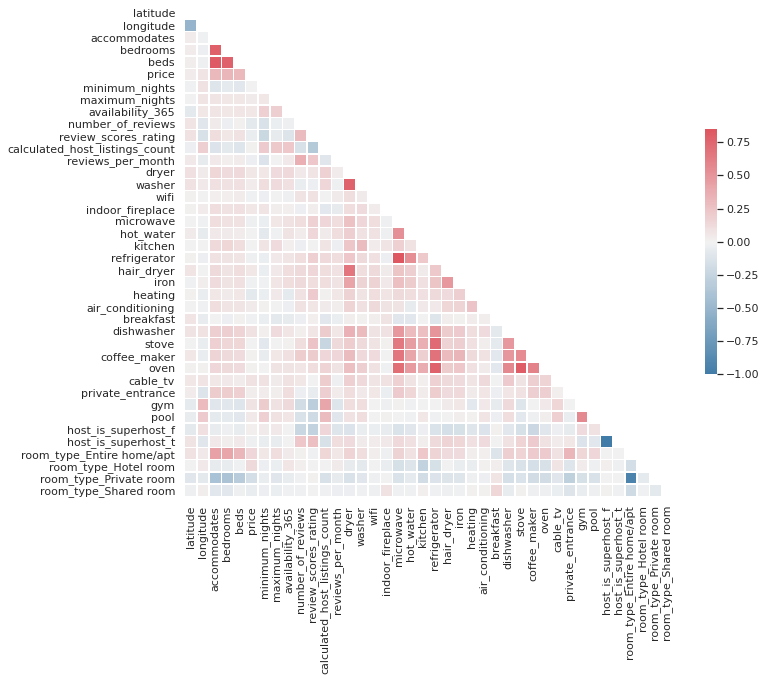

In [41]:
corr_heatmap(listing_trans.drop(list(listing_trans.columns[listing_trans.columns.str.startswith('neighbourhood')]), axis=1))

Beds and bedrooms are highly collinear features, and hence a more acute feature like acoomodation size is generally considered while checking listings. There also exists some high multi-collinearity between different amenties and listing properties.

In [42]:
listing_trans = listing_trans.drop(['beds'], axis=1)

In [43]:
#listing_trans.head(3)

In [44]:
numerical_features = ['accommodates',	'price',	'minimum_nights',	'maximum_nights',	'availability_365',	'number_of_reviews',	'review_scores_rating',	'calculated_host_listings_count',	'reviews_per_month']    

In [45]:
#listing_trans[numerical_features].hist(figsize=(10,11), color="green");

Bar availability_365, rest of the features are very skewed. Therefore we can log transform these to a normal distribution. We will still have features not benefitted from this due to their irregular distribution and large number of 0 values. We will standardize all later on using scikit-learn

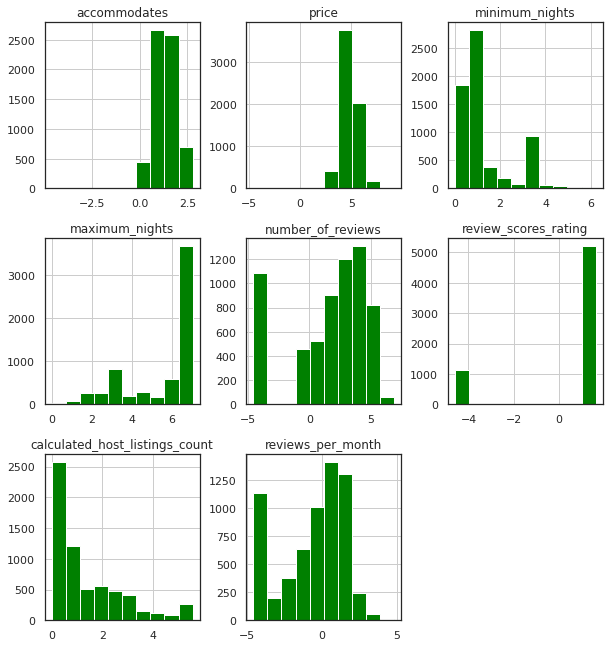

In [46]:
numerical_features = ['accommodates',	'price',	'minimum_nights',	'maximum_nights',	'number_of_reviews',	'review_scores_rating',	'calculated_host_listings_count',	'reviews_per_month']  #removing availablity_365

for col in numerical_features:
    listing_trans[col] = listing_trans[col].astype('float64').replace(0.0, 0.01)
    listing_trans[col] = np.log(listing_trans[col])

listing_trans[numerical_features].hist(figsize=(10,11), color="green");

Well, better. Now let's make the dataset for training

In [227]:
X = listing_trans.drop('price', axis=1)
y = listing_trans.price

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

# **MODEL BUILDING**

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 1) Simple linear regressor as a **baseline model**

In [240]:
# Linear regression
reg = LinearRegression()
save_1 = reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)
rmse_train = mean_squared_error(y_train, y_train_pred) ** (0.5)
rmse_test = mean_squared_error(y_test, y_test_pred) ** (0.5)
print(f"Training error(RMSE): {rmse_train}")
print(f"Testing error(RMSE): {rmse_test}")
print(f"R2: {r2_score(y_test, y_test_pred)}")

filename = 'temp\model_linear.pkl'
pickle.dump(save_1, open(filename, 'wb'))

Training error(RMSE): 0.483145132000381
Testing error(RMSE): 1316704856975.6067
R2: -2.621941521176851e+24


## 2) **Support Vector Machine** regressor

In [241]:
svr = LinearSVR(max_iter=50000)

save_2 = svr.fit(X_train, y_train)
y_train_pred = svr.predict(X_train)
print('Mean Absolute Error on Training Set:', mean_absolute_error(y_train, y_train_pred))

svr_scores = (-cross_val_score(svr, X_train, y_train,cv=10, scoring='neg_mean_absolute_error'))
svr_scores.mean()

filename = 'temp\model_svm.pkl'
pickle.dump(save_2, open(filename, 'wb'))

Mean Absolute Error on Training Set: 0.336675173178987


We can see that the above don't fit with well with any of our data subsets. To combat the non-linearity of our problem, we will employ an ensemble model and a neural network to improve our results.

## 3) Let us now look into training a Tree boosting model. We will employ a vanilla **XGBoost** model, and subsequently cross validate and tune the hyperparameters to improve the performance

In [163]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)


print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

[11:44:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 0.0 minutes

Training MSE: 0.1686
Validation MSE: 0.2444

Training r2: 0.7422
Validation r2: 0.6303


**Tuning Hyperparameters:** selecting the top important features to tune the model using Gridsearch CV with a 3 fold Cross Validation.

In [223]:
#top weighted features
imp_features = eli5.explain_weights_df(xgb_reg).iloc[:47, 0].tolist()

In [192]:
X, y = listing_trans[imp_features],\
                     listing_trans['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [193]:
xgb_reg_tune = xgb.XGBRegressor()

parameters = {'n_estimators': [10, 100, 500],
              'max_depth': [5, 20, 40, 60],
              'min_samples_leaf': [5, 10, 50],
              'max_features': ['sqrt', 'auto', 0.5, 1],
             }

grid_obj = GridSearchCV(xgb_reg_tune, parameters, scoring='neg_mean_squared_error', n_jobs=2, cv=3)
grid_fit = grid_obj.fit(X_train, y_train)

best_reg = grid_fit.best_estimator_

y_train_pred = best_reg.predict(X_train)
y_test_pred = best_reg.predict(X_test)
rmse_train = mean_squared_error(y_train, y_train_pred) ** (0.5)
rmse_test = mean_squared_error(y_test, y_test_pred) ** (0.5)
print(best_reg)
print(f"\nTraining error: {rmse_train}")
print(f"Testing error: {rmse_test}")

[13:26:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, max_features='sqrt', min_child_weight=1,
             min_samples_leaf=5, missing=None, n_estimators=500, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

Training error: 0.1778784311145691
Testing error: 0.47707107742286


In [242]:
filename = 'temp\model_xgb.pkl'
pickle.dump(best_reg, open(filename, 'wb'))

Better fit on test! We can see the improvement in the scores. Let us visualize this:

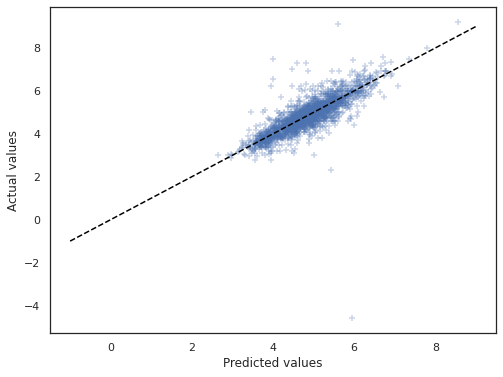

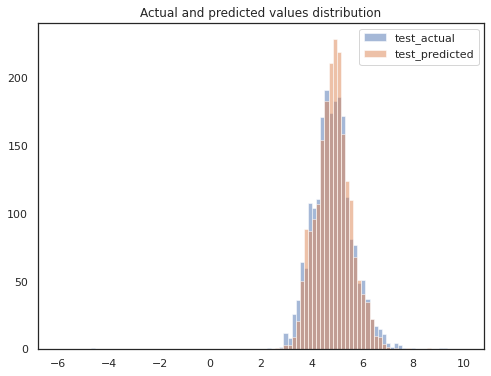

In [229]:
y_train_pred = best_reg.predict(X_train)
y_test_pred = best_reg.predict(X_test)

fig, ax= plt.subplots(1, figsize=(8,6))
ax.scatter(y_test_pred, y_test.values, alpha=0.3, marker='+')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.plot(list(range(-1,10)), list(range(-1,10)), color='black', linestyle='--')


figure(figsize=(8, 6))
bins = np.linspace(-6,10, 100)
plt.hist(y_test, bins, label='test_actual', alpha=0.5)
plt.hist(y_test_pred, bins, label='test_predicted', alpha=0.5)
plt.title('Actual and predicted values distribution')
plt.legend(loc='upper right')
plt.show()

Fitting the best model on the dataset to plot key features

[15:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


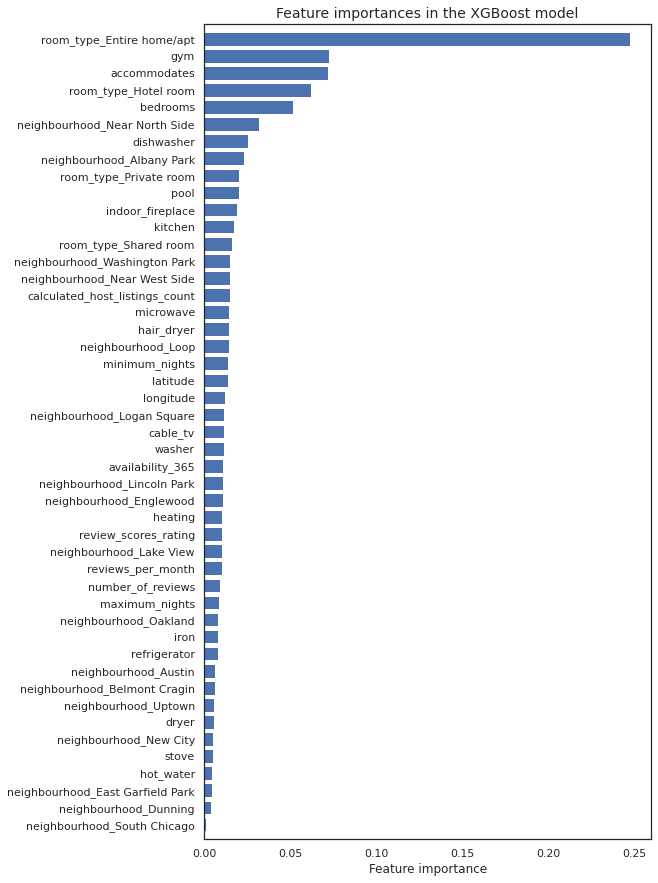

In [202]:
best_reg.fit(X_train, y_train)
weights_xgb = pd.DataFrame(best_reg.feature_importances_, columns=['weight'], index=X_train.columns)
weights_xgb.sort_values('weight', inplace=True)

#plotting feature weightages
plt.figure(figsize=(8,15))
plt.barh(weights_xgb.index, weights_xgb.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()




* As expected, the room type being an entire place is one of the key decided 
factors for prices. Next up in importance is the accomodation size, which can be inferred directly from the fact how high it ranks in the user preferences while booking a room. This has been directly employed to optimize the selection process by the design decisions in the app/website.
* We find gym being a key factor too, although it's scarcity in data, coupled with the positive correlations we found in the sample we had, made way into a higher key feature.
*   The key neighbourhoods featured in the list also rank high among the most listed neighbourhoods, as well as being costly and located in city centres. Their prices are also affected seasonally.
* After room details and neighbourhoods, another importance feature in determining the price is the number of listings by the same host. This can be accredited to the skew due to the monopoly of business listings, which manage a lot of properties. However, this very well may drive up the prices due to their reliability.







## 4) We shall now observe the performance of a **Neural Network** with **L1** regularization for the given task. We will use **ReLU** activation function, a **linear** function for the output layer and a **mean sqaured loss** as this is a regression task. 

In [208]:
X, y = listing_trans[imp_features],\
                     listing_trans['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
#FUNCTION TO EVALUATING THE MODEL
def model_eval_nn(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='red')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

Building a 4 layer model

In [207]:
#build
net = models.Sequential()
net.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
net.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
net.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
net.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
net.add(layers.Dense(1, activation='linear'))

#compiling
net.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

print(net.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               6144      
_________________________________________________________________
dense_16 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_18 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 513       
Total params: 237,057
Trainable params: 237,057
Non-trainable params: 0
_________________________________________________________________
None


In [210]:
net_start = time.time()
net_history = net.fit(X_train, y_train, epochs=150,batch_size=256,validation_split = 0.1)
net_end = time.time()

print(f"Time taken to run: {round((net_end - net_start)/60,1)} minutes")

Epoch 1/150
15/15 [==============================] - 1s 26ms/step - loss: 120.0921 - mean_squared_error: 64.8787 - val_loss: 59.6231 - val_mean_squared_error: 9.0212
Epoch 2/150
15/15 [==============================] - 0s 11ms/step - loss: 50.3460 - mean_squared_error: 3.2860 - val_loss: 45.1480 - val_mean_squared_error: 1.9078
Epoch 3/150
15/15 [==============================] - 0s 11ms/step - loss: 41.1437 - mean_squared_error: 0.8448 - val_loss: 38.0321 - val_mean_squared_error: 0.8670
Epoch 4/150
15/15 [==============================] - 0s 11ms/step - loss: 35.4643 - mean_squared_error: 0.6269 - val_loss: 33.2652 - val_mean_squared_error: 0.8527
Epoch 5/150
15/15 [==============================] - 0s 11ms/step - loss: 31.3153 - mean_squared_error: 0.6094 - val_loss: 29.8345 - val_mean_squared_error: 0.8465
Epoch 6/150
15/15 [==============================] - 0s 11ms/step - loss: 28.5053 - mean_squared_error: 0.6030 - val_loss: 27.7496 - val_mean_squared_error: 0.8547
Epoch 7/150
15

In [246]:
net.save('temp\model_NN')

INFO:tensorflow:Assets written to: temp\model_NN/assets


Training MSE: 0.3198
Test MSE: 0.3311

Training r2: 0.511
Test r2: 0.4993


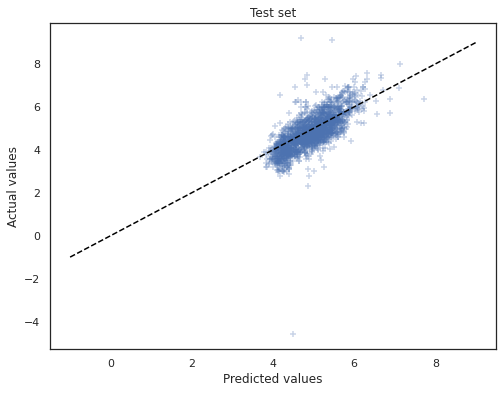

In [215]:
# MSE and r squared values
y_test_pred = net.predict(X_test)
y_train_pred = net.predict(X_train)
print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
print("Test MSE:", round(mean_squared_error(y_test, y_test_pred),4))
print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
print("Test r2:", round(r2_score(y_test, y_test_pred),4))


fig, ax= plt.subplots(1, figsize=(8,6))
ax.scatter(y_test_pred, y_test.values, alpha=0.3, marker='+')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.set_title('Test set')
ax.plot(list(range(-1,10)), list(range(-1,10)), color='black', linestyle='--')

# **CONCLUSION**



*   Even after priming the neural network with relevant activation fucntions and parameters, and the data batch having the most important features, we do not see an improvement over the XGBoost model, although it's close.
*   Such an ensemble model is less prone to overfitting than a neural network model, while giving accurate prediction boundaries.
*   So we would proceed with all prediction tasks using this tuned XGBoost model. It still doesn't explain the variation in the data, which may be due to important factors not present in the dataset.
*   This is a future workplan we can look into. One such feature which guides room booking decisions strongly are the pictures of the properties listed. We can train a suitably built neural network to study such image data and make price prediction more accurate.
*   We can also try analyse reviews and descriptions further in detail to generate a sentiment-price link for predictions.
*   With the availablity of constant data flow and seasonal data flow, we can do a time-series analysis to accurately gauge geographical and behavioural dependance of bookings with the price.

This concludes our Chicago Airbnb Data Analysis. You can also view these findings in my Streamlit dashboard here-